# Airbnb - Rio de Janeiro
* Download [data](http://insideairbnb.com/get-the-data.html)
* We downloaded `listings.csv` from all monthly dates available

## Questions
1. What was the price and supply behavior before and during the pandemic?
2. Does a title in English or Portuguese impact the price?
3. What features correlate with the price? Can we predict a price? Which features matters?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import re
import pendulum
import tqdm

import matplotlib.pyplot as plt

import langid
langid.set_languages(['en','pt'])

### Read files
Read all 30 files and get their date

In [2]:
files = sorted(glob.glob('data/listings*.csv'))

df = []
for f in files:
    date = pendulum.from_format(re.findall(r"\d{4}_\d{2}_\d{2}", f)[0], fmt="YYYY_MM_DD").naive()
    csv = pd.read_csv(f)
    csv["date"] = date
    df.append(csv)
df = pd.concat(df)
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,date
0,14063,Living in a Postcard,53598,Shalev,NaN,Botafogo,-22.946854,-43.182737,Entire home/apt,133,60,38,2018-03-04,0.38,1,363,2018-04-14
1,17878,Very Nice 2Br - Copacabana - WiFi,68997,Matthias,NaN,Copacabana,-22.965919,-43.178962,Entire home/apt,270,4,205,2018-04-10,2.17,1,286,2018-04-14
2,24480,Nice and cozy near Ipanema Beach,99249,Goya,NaN,Ipanema,-22.985698,-43.201935,Entire home/apt,222,3,85,2018-02-14,0.92,1,0,2018-04-14
3,25026,Beautiful Modern Decorated Studio in Copa,102840,Viviane,NaN,Copacabana,-22.977117,-43.190454,Entire home/apt,161,4,208,2018-03-28,2.17,3,363,2018-04-14
4,31560,NICE & COZY 1BDR - IPANEMA BEACH,135635,Renata,NaN,Ipanema,-22.983024,-43.214270,Entire home/apt,222,2,200,2018-04-01,2.12,1,345,2018-04-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25779,47219424,"Penthouse com vista panoramica, 650m², 6 suites!",376528295,Raquel,NaN,Copacabana,-22.968587,-43.186006,Entire home/apt,5800,3,0,NaN,NaN,28,365,2020-12-23
25780,47219645,"Econômico Studio, perto da praia de Copacabana",376528295,Raquel,NaN,Copacabana,-22.963107,-43.175570,Entire home/apt,195,3,0,NaN,NaN,28,365,2020-12-23
25781,47220991,Tiffany’s Charmoso e Aconchegante p/até 03,1422607,Leo&Archanjo,NaN,Ipanema,-22.986330,-43.200140,Entire home/apt,650,4,0,NaN,NaN,31,179,2020-12-23
25782,47221165,Apart-Hotel Rio Design Leblon 2604,18931103,Anthony,NaN,Leblon,-22.982700,-43.218520,Entire home/apt,1500,5,0,NaN,NaN,2,39,2020-12-23


### Deal with NaNs
* Drop `neighbourhood_group` as it is all NaNs;
* Fill `reviews_per_month` with zeros (if there is no review, then reviews per month are zero)
* Keep `name` for now
* Drop `host_name` rows, as there is not any null host_id
* Keep `last_review` too, as there are rooms with no review

In [3]:
df.isna().any()

id                                False
name                               True
host_id                           False
host_name                          True
neighbourhood_group                True
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                        True
reviews_per_month                  True
calculated_host_listings_count    False
availability_365                  False
date                              False
dtype: bool

In [4]:
df = df.drop(["host_name", "neighbourhood_group"], axis=1)
df["reviews_per_month"] = df["reviews_per_month"].fillna(0.)
df.head()

,id,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,date
0,14063,Living in a Postcard,53598,Botafogo,-22.946854,-43.182737,Entire home/apt,133,60,38,2018-03-04,0.38,1,363,2018-04-14
1,17878,Very Nice 2Br - Copacabana - WiFi,68997,Copacabana,-22.965919,-43.178962,Entire home/apt,270,4,205,2018-04-10,2.17,1,286,2018-04-14
2,24480,Nice and cozy near Ipanema Beach,99249,Ipanema,-22.985698,-43.201935,Entire home/apt,222,3,85,2018-02-14,0.92,1,0,2018-04-14
3,25026,Beautiful Modern Decorated Studio in Copa,102840,Copacabana,-22.977117,-43.190454,Entire home/apt,161,4,208,2018-03-28,2.17,3,363,2018-04-14
4,31560,NICE & COZY 1BDR - IPANEMA BEACH,135635,Ipanema,-22.983024,-43.214270,Entire home/apt,222,2,200,2018-04-01,2.12,1,345,2018-04-14


### Detect `name` language
* Clean strings for evaluation
* Remove common neighbourhoods name in Portuguese from `name` column to diminish misprediction
* Remove several non-alphanumeric characters
* Detect language using [langid](https://github.com/saffsd/langid.py)
* I restricted between pt, en. There are very few rooms listed in other languages.
* Drop `name` column

In [5]:
import unicodedata

In [6]:
stopwords = pd.unique(df["neighbourhood"])
stopwords = [re.sub(r"[\(\)]", "", x.lower().strip()).split() for x in stopwords]
stopwords = [x for item in stopwords for x in item]
stopwords += [unicodedata.normalize("NFKD", x).encode('ASCII', 'ignore').decode() for x in stopwords]
stopwords += ["rio", "janeiro", "copa", "arpoador", "pepê", "pepe", "lapa", "morro", "corcovado"]
stopwords = set(stopwords)

In [7]:
docs = [re.sub(r"[\-\_\\\/\,\;\:\!\+\’\%\&\d\*\#\"\´\`\.\|\(\)\[\]\@\'\»\«\>\<\❤️\…]", " ", str(x)) for x in df["name"].tolist()]
docs = [" ".join(x.lower().strip().split()) for x in docs]
docs = ["".join(e for e in x if (e.isalnum() or " ")) for x in docs]

In [8]:
ndocs = []
for doc in tqdm.tqdm(docs):
    ndocs.append(" ".join([x for x in doc.split() if x not in stopwords]))
docs = ndocs

100%|██████████| 1047691/1047691 [00:01<00:00, 649856.94it/s]


In [9]:
results = []
for d in tqdm.tqdm(docs):
    results.append(langid.classify(d)[0])

100%|██████████| 1047691/1047691 [01:10<00:00, 14788.52it/s]


In [10]:
df["language"] = results

# Because we transformed NaNs into string, fill those detection with nans too
df.loc[df["name"].isna(), "language"] = pd.NA

* Test accuracy, manually label 383 out of 88191 (95% conf. interval, 5% margin of error)

In [11]:
df.loc[~df["name"].isna()].drop_duplicates("name").shape

(88191, 16)

In [12]:
df.loc[~df["name"].isna()].drop_duplicates("name")[["name", "language"]].sample(n=383, random_state=42).to_csv("lang_pred_1.csv")

In [13]:
lang_pred = pd.read_csv("lang_pred.csv", index_col=0)
lang_pred.head()

,name,pred,true
35551,Venha se hospedar em um lindo quarto na Tijuca,pt,pt
14931,Casa em condomínio para Olimpíadas,pt,pt
32377,Quarto privado em Copacabana,pt,pt
24095,Lapa,en,en
14297,Flat com cozinha reformado no Leme (Copacabana),pt,pt


In [14]:
overall_accuracy = (lang_pred["pred"] == lang_pred["true"]).sum() / lang_pred.shape[0]
pt_accuracy = (lang_pred[lang_pred["true"] == "pt"]["true"] == lang_pred[lang_pred["true"] == "pt"]["pred"]).sum() / lang_pred[lang_pred["true"] == "pt"].shape[0]
en_accuracy = (lang_pred[lang_pred["true"] == "en"]["true"] == lang_pred[lang_pred["true"] == "en"]["pred"]).sum() / lang_pred[lang_pred["true"] == "en"].shape[0]
print(f"Overall accuracy: {overall_accuracy*100}%")
print(f"Portuguese accuracy: {pt_accuracy*100}%")
print(f"English accuracy: {en_accuracy*100}%")

Overall accuracy: 92.95039164490862%
Portuguese accuracy: 92.67241379310344%
English accuracy: 95.27027027027027%


In [15]:
df = df.drop("name", axis=1)
df.head()

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,date,language
0,14063,53598,Botafogo,-22.946854,-43.182737,Entire home/apt,133,60,38,2018-03-04,0.38,1,363,2018-04-14,en
1,17878,68997,Copacabana,-22.965919,-43.178962,Entire home/apt,270,4,205,2018-04-10,2.17,1,286,2018-04-14,en
2,24480,99249,Ipanema,-22.985698,-43.201935,Entire home/apt,222,3,85,2018-02-14,0.92,1,0,2018-04-14,en
3,25026,102840,Copacabana,-22.977117,-43.190454,Entire home/apt,161,4,208,2018-03-28,2.17,3,363,2018-04-14,en
4,31560,135635,Ipanema,-22.983024,-43.214270,Entire home/apt,222,2,200,2018-04-01,2.12,1,345,2018-04-14,en


In [16]:
df["language"].value_counts()

pt    578980
en    466836
Name: language, dtype: int64

### Calculate how many times a room appeared
* There are 30 months of data, and rooms appear multiple times
* Calculate for a specific date, how many times the same room appeared up to that date

In [17]:
df = df.set_index(["id", "date"])
df["appearances"] = df.groupby(["id", "date"])["host_id"].count().unstack().cumsum(axis=1).stack()
df = df.reset_index()
df.head()

,id,date,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,language,appearances
0,14063,2018-04-14,53598,Botafogo,-22.946854,-43.182737,Entire home/apt,133,60,38,2018-03-04,0.38,1,363,en,1.0
1,17878,2018-04-14,68997,Copacabana,-22.965919,-43.178962,Entire home/apt,270,4,205,2018-04-10,2.17,1,286,en,1.0
2,24480,2018-04-14,99249,Ipanema,-22.985698,-43.201935,Entire home/apt,222,3,85,2018-02-14,0.92,1,0,en,1.0
3,25026,2018-04-14,102840,Copacabana,-22.977117,-43.190454,Entire home/apt,161,4,208,2018-03-28,2.17,3,363,en,1.0
4,31560,2018-04-14,135635,Ipanema,-22.983024,-43.214270,Entire home/apt,222,2,200,2018-04-01,2.12,1,345,en,1.0


### Days since last review
* Calculate days since last review
* Then categorize them by the length of the days

In [18]:
df.loc[:, "last_review"] = pd.to_datetime(df["last_review"], format="%Y/%m/%d")

In [19]:
# For each scraping date, consider the last date to serve as comparision as the maximum date
last_date = df.groupby("date")["last_review"].max()
df["last_date"] = df.apply(lambda row: last_date.loc[row["date"]], axis=1)

In [20]:
df["days_last_review"] = (df["last_date"] - df["last_review"]).dt.days

In [21]:
df = df.drop("last_date", axis=1)
df.head()

,id,date,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,language,appearances,days_last_review
0,14063,2018-04-14,53598,Botafogo,-22.946854,-43.182737,Entire home/apt,133,60,38,2018-03-04,0.38,1,363,en,1.0,41.0
1,17878,2018-04-14,68997,Copacabana,-22.965919,-43.178962,Entire home/apt,270,4,205,2018-04-10,2.17,1,286,en,1.0,4.0
2,24480,2018-04-14,99249,Ipanema,-22.985698,-43.201935,Entire home/apt,222,3,85,2018-02-14,0.92,1,0,en,1.0,59.0
3,25026,2018-04-14,102840,Copacabana,-22.977117,-43.190454,Entire home/apt,161,4,208,2018-03-28,2.17,3,363,en,1.0,17.0
4,31560,2018-04-14,135635,Ipanema,-22.983024,-43.214270,Entire home/apt,222,2,200,2018-04-01,2.12,1,345,en,1.0,13.0


In [22]:
df["days_last_review"].describe()

count    565753.000000
mean        328.459207
std         416.559325
min           0.000000
25%          38.000000
50%         147.000000
75%         461.000000
max        3231.000000
Name: days_last_review, dtype: float64

In [23]:
def categorize_last_review(days_last_review):
    if days_last_review <= 7:
        return "last_week"
    elif days_last_review <= 30:
        return "last_month"
    elif days_last_review <= 182:
        return "last_half_year"
    elif days_last_review <= 365:
        return "last_year"
    elif days_last_review <= 730:
        return "last_two_years"
    elif days_last_review > 730:
        return "long_time_ago"
    else:
        return "never"
    
df.loc[:, "last_review"] = df.apply(lambda row: categorize_last_review(row["days_last_review"]), axis=1)

In [24]:
df = df.drop(["days_last_review"], axis=1)
df.head()

,id,date,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,language,appearances
0,14063,2018-04-14,53598,Botafogo,-22.946854,-43.182737,Entire home/apt,133,60,38,last_half_year,0.38,1,363,en,1.0
1,17878,2018-04-14,68997,Copacabana,-22.965919,-43.178962,Entire home/apt,270,4,205,last_week,2.17,1,286,en,1.0
2,24480,2018-04-14,99249,Ipanema,-22.985698,-43.201935,Entire home/apt,222,3,85,last_half_year,0.92,1,0,en,1.0
3,25026,2018-04-14,102840,Copacabana,-22.977117,-43.190454,Entire home/apt,161,4,208,last_month,2.17,3,363,en,1.0
4,31560,2018-04-14,135635,Ipanema,-22.983024,-43.214270,Entire home/apt,222,2,200,last_month,2.12,1,345,en,1.0


In [25]:
df = df.set_index(["id", "date"])

df.loc[:, "appearances"] = df["appearances"].astype(int)

df.loc[:, "host_id"] = df["host_id"].astype("category")
df.loc[:, "neighbourhood"] = df["neighbourhood"].astype("category")
df.loc[:, "room_type"] = df["room_type"].astype("category")
df.loc[:, "last_review"] = df["last_review"].astype("category")
df.loc[:, "language"] = df["language"].astype("category")

In [26]:
df

,,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,language,appearances
id,date,,,,,,,,,,,,,,
14063,2018-04-14,53598,Botafogo,-22.946854,-43.182737,Entire home/apt,133,60,38,last_half_year,0.38,1,363,en,1
17878,2018-04-14,68997,Copacabana,-22.965919,-43.178962,Entire home/apt,270,4,205,last_week,2.17,1,286,en,1
24480,2018-04-14,99249,Ipanema,-22.985698,-43.201935,Entire home/apt,222,3,85,last_half_year,0.92,1,0,en,1
25026,2018-04-14,102840,Copacabana,-22.977117,-43.190454,Entire home/apt,161,4,208,last_month,2.17,3,363,en,1
31560,2018-04-14,135635,Ipanema,-22.983024,-43.214270,Entire home/apt,222,2,200,last_month,2.12,1,345,en,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47219424,2020-12-23,376528295,Copacabana,-22.968587,-43.186006,Entire home/apt,5800,3,0,never,0.00,28,365,en,1
47219645,2020-12-23,376528295,Copacabana,-22.963107,-43.175570,Entire home/apt,195,3,0,never,0.00,28,365,pt,1
47220991,2020-12-23,1422607,Ipanema,-22.986330,-43.200140,Entire home/apt,650,4,0,never,0.00,31,179,pt,1


In [27]:
df.to_pickle("data.pkl")

### Distributions
* Check the distribution of features

In [28]:
df = pd.read_pickle("data.pkl")
df.head()

,,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,language,appearances
id,date,,,,,,,,,,,,,,
14063,2018-04-14,53598,Botafogo,-22.946854,-43.182737,Entire home/apt,133,60,38,last_half_year,0.38,1,363,en,1
17878,2018-04-14,68997,Copacabana,-22.965919,-43.178962,Entire home/apt,270,4,205,last_week,2.17,1,286,en,1
24480,2018-04-14,99249,Ipanema,-22.985698,-43.201935,Entire home/apt,222,3,85,last_half_year,0.92,1,0,en,1
25026,2018-04-14,102840,Copacabana,-22.977117,-43.190454,Entire home/apt,161,4,208,last_month,2.17,3,363,en,1
31560,2018-04-14,135635,Ipanema,-22.983024,-43.214270,Entire home/apt,222,2,200,last_month,2.12,1,345,en,1


<AxesSubplot:>

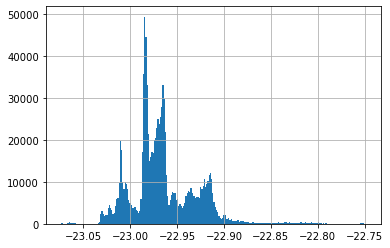

In [29]:
df["latitude"].hist(bins=250)

<AxesSubplot:>

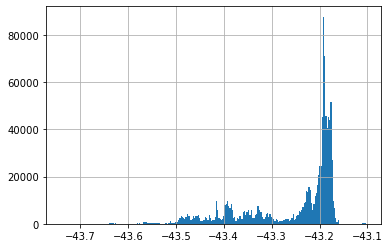

In [30]:
df["longitude"].hist(bins=250)

<AxesSubplot:>

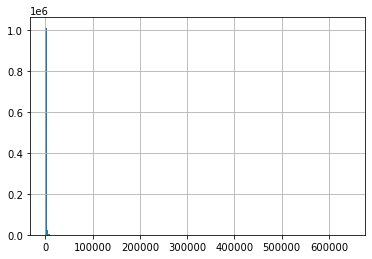

In [31]:
df["price"].hist(bins=250)

<AxesSubplot:>

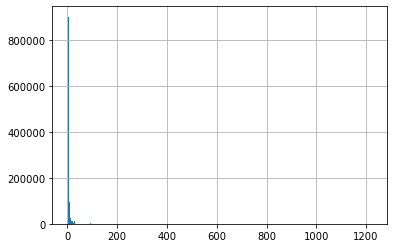

In [32]:
df["minimum_nights"].hist(bins=250)

<AxesSubplot:>

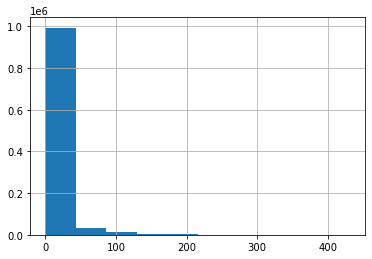

In [33]:
df["number_of_reviews"].hist()

<AxesSubplot:>

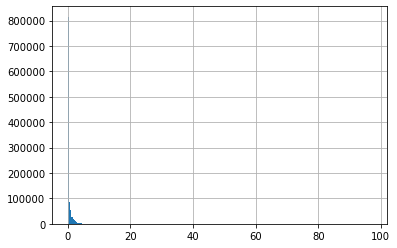

In [34]:
df["reviews_per_month"].hist(bins=250)

<AxesSubplot:>

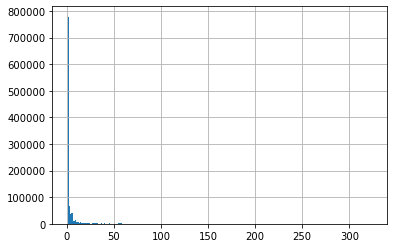

In [35]:
df["calculated_host_listings_count"].hist(bins=250)

<AxesSubplot:>

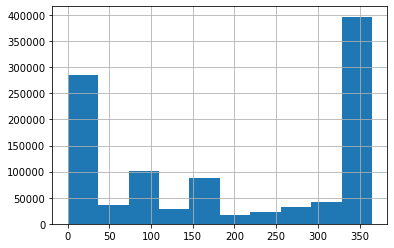

In [36]:
df["availability_365"].hist()

<AxesSubplot:>

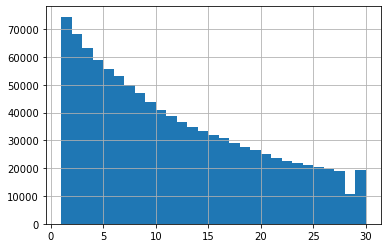

In [37]:
df["appearances"].hist(bins=29)

In [38]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,appearances
count,1.047691e+06,1.047691e+06,1.047691e+06,1.047691e+06,1.047691e+06,1.047691e+06,1.047691e+06,1.047691e+06,1.047691e+06
mean,-2.296529e+01,-4.325344e+01,6.645807e+02,4.594204e+00,8.147470e+00,3.300135e-01,6.562377e+00,1.942882e+02,1.137763e+01
std,3.484186e-02,9.731996e-02,2.225085e+03,2.077848e+01,2.271796e+01,6.930495e-01,2.508461e+01,1.524306e+02,8.008354e+00
min,-2.307340e+01,-4.373892e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,-2.298466e+01,-4.332174e+01,1.520000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.200000e+01,4.000000e+00
50%,-2.297069e+01,-4.319983e+01,2.980000e+02,2.000000e+00,1.000000e+00,4.000000e-02,1.000000e+00,1.800000e+02,1.000000e+01
75%,-2.294622e+01,-4.318686e+01,6.010000e+02,4.000000e+00,5.000000e+00,3.100000e-01,3.000000e+00,3.620000e+02,1.700000e+01
max,-2.274895e+01,-4.310371e+01,6.441210e+05,1.224000e+03,4.310000e+02,9.716000e+01,3.240000e+02,3.650000e+02,3.000000e+01


### Limits
* We are analising mostly for touristic purpose, so get the short-term rentals only
* Prices between 10 and 10000 (The luxury Copacabana Palace Penthouse at 8000 for example)
* Short-term rentals (minimum_nights < 31)
* Impossibility of more than 31 reviews per month

In [39]:
df = pd.read_pickle("data.pkl")
total_records = len(df)

In [40]:
outbound_values = (df["price"] < 10) | (df["price"] > 10000)
df = df[~outbound_values]

print(f"Removed values {outbound_values.sum()}, {outbound_values.sum()*100/total_records}%")

Removed values 5069, 0.48382586086928303%


In [41]:
long_term = df["minimum_nights"] >= 31
df = df[~long_term]

print(f"Removed values {long_term.sum()}, {long_term.sum()*100/total_records}%")

Removed values 5742, 0.54806235808077%


In [42]:
reviews_limit = df["reviews_per_month"] > 31
df = df[~reviews_limit]

print(f"Removed values {reviews_limit.sum()}, {reviews_limit.sum()*100/total_records}%")

Removed values 2, 0.00019089597982611286%


### Log skewed variables
* Most numerical values are skewed, so log them

In [43]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,appearances
count,1.036878e+06,1.036878e+06,1.036878e+06,1.036878e+06,1.036878e+06,1.036878e+06,1.036878e+06,1.036878e+06,1.036878e+06
mean,-2.296524e+01,-4.325337e+01,5.662000e+02,3.562250e+00,8.202351e+00,3.324247e-01,6.512900e+00,1.941023e+02,1.136111e+01
std,3.483652e-02,9.733976e-02,8.713987e+02,4.169784e+00,2.278699e+01,6.861982e-01,2.496588e+01,1.523387e+02,8.005921e+00
min,-2.307340e+01,-4.373892e+01,1.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,-2.298463e+01,-4.332163e+01,1.520000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.200000e+01,4.000000e+00
50%,-2.297067e+01,-4.319976e+01,2.960000e+02,2.000000e+00,1.000000e+00,4.000000e-02,1.000000e+00,1.800000e+02,1.000000e+01
75%,-2.294616e+01,-4.318684e+01,6.010000e+02,4.000000e+00,5.000000e+00,3.100000e-01,3.000000e+00,3.620000e+02,1.700000e+01
max,-2.274895e+01,-4.310371e+01,1.000000e+04,3.000000e+01,4.310000e+02,1.657000e+01,3.240000e+02,3.650000e+02,3.000000e+01


In [44]:
# number_of_reviews, reviews_per_month, availability_365 have zeros, thus sum one to all
df["number_of_reviews"] = np.log(df["number_of_reviews"] + 1)
df["reviews_per_month"] = np.log(df["reviews_per_month"] + 1)
df["availability_365"] = np.log(df["availability_365"] + 1)

In [45]:
df["price"] = np.log(df["price"])
df["minimum_nights"] = np.log(df["minimum_nights"])
df["calculated_host_listings_count"] = np.log(df["calculated_host_listings_count"])
df["appearances"] = np.log(df["appearances"])

In [46]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,appearances
count,1.036878e+06,1.036878e+06,1.036878e+06,1.036878e+06,1.036878e+06,1.036878e+06,1.036878e+06,1.036878e+06,1.036878e+06
mean,-2.296524e+01,-4.325337e+01,5.768649e+00,9.074971e-01,1.050266e+00,2.112680e-01,6.659690e-01,4.058696e+00,2.085767e+00
std,3.483652e-02,9.733976e-02,1.000062e+00,7.812643e-01,1.297620e+00,3.440206e-01,1.084768e+00,2.375321e+00,9.376039e-01
min,-2.307340e+01,-4.373892e+01,2.397895e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-2.298463e+01,-4.332163e+01,5.023881e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.564949e+00,1.386294e+00
50%,-2.297067e+01,-4.319976e+01,5.690359e+00,6.931472e-01,6.931472e-01,3.922071e-02,0.000000e+00,5.198497e+00,2.302585e+00
75%,-2.294616e+01,-4.318684e+01,6.398595e+00,1.386294e+00,1.791759e+00,2.700271e-01,1.098612e+00,5.894403e+00,2.833213e+00
max,-2.274895e+01,-4.310371e+01,9.210340e+00,3.401197e+00,6.068426e+00,2.866193e+00,5.780744e+00,5.902633e+00,3.401197e+00


### Extreme outliers
* Most outliers are clearly mistyped values (one can check these rooms ids in their website)
* Remove extreme outliers first from large deviations within the same `id` (eliminate rate jumps of same room)
* Then remove those from same scraping `date`, `neighbourhood` and `room_type`

In [47]:
df = df.reset_index()

In [48]:
q25 = df.groupby(["id"])["price"].quantile(0.25)
q75 = df.groupby(["id"])["price"].quantile(0.75)

ext = q75 + 3 * (q75 - q25)
ext = ext[(q75 - q25) > 0.]

In [49]:
affected_rows = []
multiple_id = df[df["id"].isin(ext.index)]
for row in tqdm.tqdm(multiple_id.itertuples(), total=len(multiple_id)):
    if row.price >= ext.loc[row.id]:
        affected_rows.append(row.Index)

100%|██████████| 1023406/1023406 [00:14<00:00, 70302.71it/s]


In [50]:
df = df.drop(affected_rows)
print(f"Removed values {len(affected_rows)}, {len(affected_rows)*100/total_records}%")

Removed values 21078, 2.0118527313874033%


In [51]:
# Remove extreme outliers per neighbourhood, room_type and scraping date
q25 = df.groupby(["date", "neighbourhood", "room_type"])["price"].quantile(0.25)
q75 = df.groupby(["date", "neighbourhood", "room_type"])["price"].quantile(0.75)
ext = q75 + 3 * (q75 - q25)
ext

date        neighbourhood  room_type      
2018-04-14  Abolição       Entire home/apt    7.212211
                           Hotel room              NaN
                           Private room       6.211867
                           Shared room        4.442651
            Acari          Entire home/apt         NaN
                                                ...   
2020-12-23  Zumbi          Shared room             NaN
            Água Santa     Entire home/apt         NaN
                           Hotel room              NaN
                           Private room            NaN
                           Shared room             NaN
Name: price, Length: 19200, dtype: float64

In [52]:
affected_rows = []
for row in tqdm.tqdm(df.itertuples(), total=len(df)):
    if row.price >= ext.loc[(row.date, row.neighbourhood, row.room_type)]:
        affected_rows.append(row.Index)

100%|██████████| 1015800/1015800 [01:30<00:00, 11223.94it/s]


In [53]:
df = df.drop(affected_rows)
print(f"Removed values {len(affected_rows)}, {len(affected_rows)*100/total_records}%")

Removed values 3528, 0.3367405084132631%


In [54]:
df.describe()

,id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,appearances
count,1.012272e+06,1.012272e+06,1.012272e+06,1.012272e+06,1.012272e+06,1.012272e+06,1.012272e+06,1.012272e+06,1.012272e+06,1.012272e+06
mean,1.713074e+07,-2.296541e+01,-4.325347e+01,5.765412e+00,9.094330e-01,1.037147e+00,2.094717e-01,6.618867e-01,4.042640e+00,2.076617e+00
std,1.141133e+07,3.453738e-02,9.735275e-02,9.982576e-01,7.833735e-01,1.289827e+00,3.432646e-01,1.082260e+00,2.385452e+00,9.323510e-01
min,1.787800e+04,-2.307340e+01,-4.373892e+01,2.397895e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.744607e+06,-2.298464e+01,-4.332195e+01,5.017280e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.302585e+00,1.386294e+00
50%,1.407131e+07,-2.297067e+01,-4.319979e+01,5.683580e+00,6.931472e-01,6.931472e-01,3.922071e-02,0.000000e+00,5.192957e+00,2.302585e+00
75%,2.335594e+07,-2.294639e+01,-4.318685e+01,6.398595e+00,1.386294e+00,1.791759e+00,2.700271e-01,1.098612e+00,5.894403e+00,2.833213e+00
max,4.722176e+07,-2.274895e+01,-4.310371e+01,9.210340e+00,3.401197e+00,6.061457e+00,2.866193e+00,5.780744e+00,5.902633e+00,3.401197e+00


<AxesSubplot:>

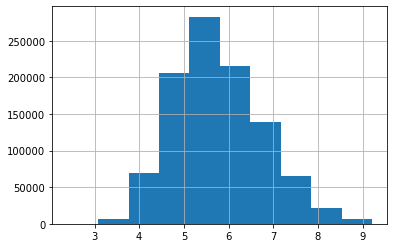

In [55]:
df["price"].hist()

In [56]:
df.to_pickle("treated_data.pkl")